In [ ]:
import pandas as pd
import numpy as np
from itertools import product
from numba import njit
import os
from IPython.display import display
import matplotlib.pyplot as plt

# 数据文件路径
data_dir = '../data'
csv_filename = 'data_SH_000922_2016-01-01_2025-02-23.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

In [2]:
# 随机指标计算（矢量化）
def Stochastic(high, low, close, k_period, d_period):
    low_min = low.rolling(window=k_period, min_periods=1).min()
    high_max = high.rolling(window=k_period, min_periods=1).max()
    k = 100 * (close - low_min) / (high_max - low_min)
    d = k.rolling(window=d_period, min_periods=1).mean()
    return k, d

# ATR计算（矢量化）
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=period, min_periods=1).mean()

# Numba加速未来范围计算
@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

# 矢量化信号检测，区分显性和隐秘强信号
def detect_stochastic_signals_vectorized(df, k_period=14, d_period=3, overbought=80, oversold=20, ma_period=20, atr_period_explicit=14, atr_period_hidden=14, strength_threshold=0.1):
    df = df.copy()
    k, d = Stochastic(df['high'], df['low'], df['close'], k_period, d_period)
    ma = df['close'].rolling(window=ma_period, min_periods=1).mean()
    atr_explicit = ATR(df['high'], df['low'], df['close'], period=atr_period_explicit)
    atr_hidden = ATR(df['high'], df['low'], df['close'], period=atr_period_hidden)
    atr_avg = (atr_explicit + atr_hidden) / 2

    df['signal_strength'] = abs(k - d)
    df['k_amplitude'] = df['high'] - df['low']
    
    dynamic_threshold = strength_threshold * (atr_avg / atr_avg.mean())
    k_amplitude_upper = df['k_amplitude'].quantile(0.80)
    k_amplitude_lower = df['k_amplitude'].quantile(0.20)

    support_condition = (k > d) & (k.shift(1) <= d.shift(1)) & (k < oversold) & (df['close'] < ma)
    resistance_condition = (k < d) & (k.shift(1) >= d.shift(1)) & (k > overbought) & (df['close'] > ma)
    
    df['reversal'] = np.select([support_condition, resistance_condition], ['support reversal', 'resistance reversal'], default='none')
    
    df['is_strong_explicit'] = np.where(
        (df['reversal'] != 'none') & 
        (df['signal_strength'] >= dynamic_threshold) & 
        (df['k_amplitude'] > k_amplitude_upper),
        1, 0
    )
    
    df['is_strong_hidden'] = np.where(
        (df['reversal'] != 'none') & 
        (df['signal_strength'] >= dynamic_threshold) & 
        (df['k_amplitude'] < k_amplitude_lower) & 
        (abs(df['close'] - ma) < atr_hidden),
        1, 0
    )
    
    df['is_strong'] = np.where((df['is_strong_explicit'] == 1) | (df['is_strong_hidden'] == 1), 1, 0)
    
    return df

def calculate_win_rate(df, look_ahead=10, target_multiplier=1):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=df['atr_period_explicit'].iloc[0] if 'atr_period_explicit' in df.columns else 14)
    
    df['support_target'] = df['close'] + df['atr'] * target_multiplier
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    df['support_win'] = np.where(
        (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']),
        1, 0
    )
    df['resistance_win'] = np.where(
        (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']),
        1, 0
    )
    
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    
    strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong'] == 1)]
    strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong'] == 1)]
    strong_support_win_rate = strong_support_signals['support_win'].mean() if len(strong_support_signals) > 0 else 0
    strong_resistance_win_rate = strong_resistance_signals['resistance_win'].mean() if len(strong_resistance_signals) > 0 else 0
    
    explicit_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_explicit'] == 1)]
    explicit_strong_support_win_rate = explicit_strong_support_signals['support_win'].mean() if len(explicit_strong_support_signals) > 0 else 0
    explicit_strong_resistance_win_rate = explicit_strong_resistance_signals['resistance_win'].mean() if len(explicit_strong_resistance_signals) > 0 else 0
    
    hidden_strong_support_signals = df[(df['reversal'] == 'support reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_resistance_signals = df[(df['reversal'] == 'resistance reversal') & (df['is_strong_hidden'] == 1)]
    hidden_strong_support_win_rate = hidden_strong_support_signals['support_win'].mean() if len(hidden_strong_support_signals) > 0 else 0
    hidden_strong_resistance_win_rate = hidden_strong_resistance_signals['resistance_win'].mean() if len(hidden_strong_resistance_signals) > 0 else 0
    
    support_recall = len(strong_support_signals) / len(support_signals) if len(support_signals) > 0 else 0
    resistance_recall = len(strong_resistance_signals) / len(resistance_signals) if len(resistance_signals) > 0 else 0
    
    return {
        'support_win_rate': support_win_rate,
        'support_signals_count': len(support_signals),
        'resistance_win_rate': resistance_win_rate,
        'resistance_signals_count': len(resistance_signals),
        'strong_support_win_rate': strong_support_win_rate,
        'strong_support_signals_count': len(strong_support_signals),
        'strong_resistance_win_rate': strong_resistance_win_rate,
        'strong_resistance_signals_count': len(strong_resistance_signals),
        'explicit_strong_support_win_rate': explicit_strong_support_win_rate,
        'explicit_strong_support_signals_count': len(explicit_strong_support_signals),
        'explicit_strong_resistance_win_rate': explicit_strong_resistance_win_rate,
        'explicit_strong_resistance_signals_count': len(explicit_strong_resistance_signals),
        'hidden_strong_support_win_rate': hidden_strong_support_win_rate,
        'hidden_strong_support_signals_count': len(hidden_strong_support_signals),
        'hidden_strong_resistance_win_rate': hidden_strong_resistance_win_rate,
        'hidden_strong_resistance_signals_count': len(hidden_strong_resistance_signals),
        'support_recall': support_recall,
        'resistance_recall': resistance_recall,
        'detailed_df': df
    }

In [3]:
# 一步网格优化：优化所有参数，单线程运行
def optimize_parameters(df, k_periods=[9, 15, 21], d_periods=[3, 5, 7], overbought_levels=[70, 80, 90], oversold_levels=[10, 20, 30], ma_periods=[10, 20, 60], atr_periods_explicit=[7, 14, 20], atr_periods_hidden=[7, 14, 20], strength_thresholds=[0.1, 0.2, 0.3], look_ahead=10, target_multiplier=1.0, min_signal_ratio=0.05):
    best_params = None
    best_score = -1
    param_results = []

    min_signal_threshold = int(len(df) * min_signal_ratio)

    for params in product(k_periods, d_periods, overbought_levels, oversold_levels, ma_periods, atr_periods_explicit, atr_periods_hidden, strength_thresholds):
        k_period, d_period, overbought, oversold, ma_period, atr_period_explicit, atr_period_hidden, strength_threshold = params
        df_with_signals = detect_stochastic_signals_vectorized(df.copy(), k_period, d_period, overbought, oversold, ma_period, atr_period_explicit, atr_period_hidden, strength_threshold)
        result = calculate_win_rate(df_with_signals, look_ahead, target_multiplier)

        # 简单评分：胜率和召回率的加权平均
        score = 0.6 * (result['strong_support_win_rate'] + result['strong_resistance_win_rate']) / 2 + \
                0.4 * (result['support_recall'] + result['resistance_recall']) / 2
        
        # 信号数量惩罚
        if min(result['support_signals_count'], result['resistance_signals_count']) < min_signal_threshold:
            score *= 0.5

        param_results.append({'params': params, 'score': score})
        if score > best_score:
            best_score = score
            best_params = {'k_period': k_period, 'd_period': d_period, 'overbought': overbought, 'oversold': oversold, 'ma_period': ma_period, 'atr_period_explicit': atr_period_explicit, 'atr_period_hidden': atr_period_hidden, 'strength_threshold': strength_threshold}

    return best_params, param_results

# 执行一步优化
best_params, param_results = optimize_parameters(df)

# 使用最佳参数计算最终信号
df = detect_stochastic_signals_vectorized(
    df, best_params['k_period'], best_params['d_period'], best_params['overbought'], best_params['oversold'], 
    best_params['ma_period'], best_params['atr_period_explicit'], best_params['atr_period_hidden'], best_params['strength_threshold']
)
result = calculate_win_rate(df)

Best Parameters: {'k_period': 21, 'd_period': 3, 'overbought': 70, 'oversold': 30, 'ma_period': 20, 'atr_period_explicit': 7, 'atr_period_hidden': 7, 'strength_threshold': 0.1}
Overall Support Reversal Win Rate: 60.16% (Signals: 123)
Overall Resistance Reversal Win Rate: 68.62% (Signals: 188)
Strong Support Reversal Win Rate: 44.74% (Signals: 38)
Strong Resistance Reversal Win Rate: 78.57% (Signals: 42)
Explicit Strong Support Win Rate: 41.67% (Signals: 36)
Explicit Strong Resistance Win Rate: 77.14% (Signals: 35)
Hidden Strong Support Win Rate: 100.00% (Signals: 2)
Hidden Strong Resistance Win Rate: 85.71% (Signals: 7)
Support Recall: 30.89%
Resistance Recall: 22.34%

Detailed DataFrame saved to: ./data/stochastic_signals_optimized.csv

Detailed DataFrame (Last 250 Rows):


,open,high,low,close,volume,reversal,signal_strength,is_strong,is_strong_explicit,is_strong_hidden,support_target,resistance_target,future_high,future_low,support_win,resistance_win
2024-02-02,5029.8904,5108.7568,4923.5157,5024.7982,6233573123,none,4.069621,0,0,0,5133.044300,4916.552100,5513.8787,4907.3229,0,0
2024-02-05,5008.1490,5078.8917,4907.3229,5020.6780,7825655699,none,0.850249,0,0,0,5137.291907,4904.064093,5513.8787,4970.2292,0,0
2024-02-06,4985.0414,5167.7826,4970.2292,5139.1514,7502522479,none,16.189381,0,0,0,5264.039129,5014.263671,5513.8787,5094.5691,0,0
2024-02-07,5135.0568,5240.3177,5094.5691,5240.3177,8855457971,none,18.574219,0,0,0,5364.107236,5116.528164,5513.8787,5209.6130,0,0
2024-02-08,5228.1083,5295.3556,5209.6130,5244.2155,7338960570,resistance reversal,0.906297,1,1,0,5370.381450,5118.049550,5513.8787,5212.5383,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-17,5355.8645,5358.3226,5313.3836,5336.5732,4932700873,none,3.176051,0,0,0,5395.555029,5277.591371,NaN,NaN,0,0
2025-02-18,5329.4705,5361.6783,5303.7961,5318.6352,5726591491,none,8.673126,0,0,0,5377.423121,5259.847279,NaN,NaN,0,0
2025-02-19,5312.2783,5314.5919,5289.1693,5303.6980,4906655405,none,10.699279,0,0,0,5359.495879,5247.900121,NaN,NaN,0,0
2025-02-20,5298.2954,5303.5861,5277.2776,5291.0318,3891183252,none,10.471703,0,0,0,5342.814150,5239.249450,NaN,NaN,0,0


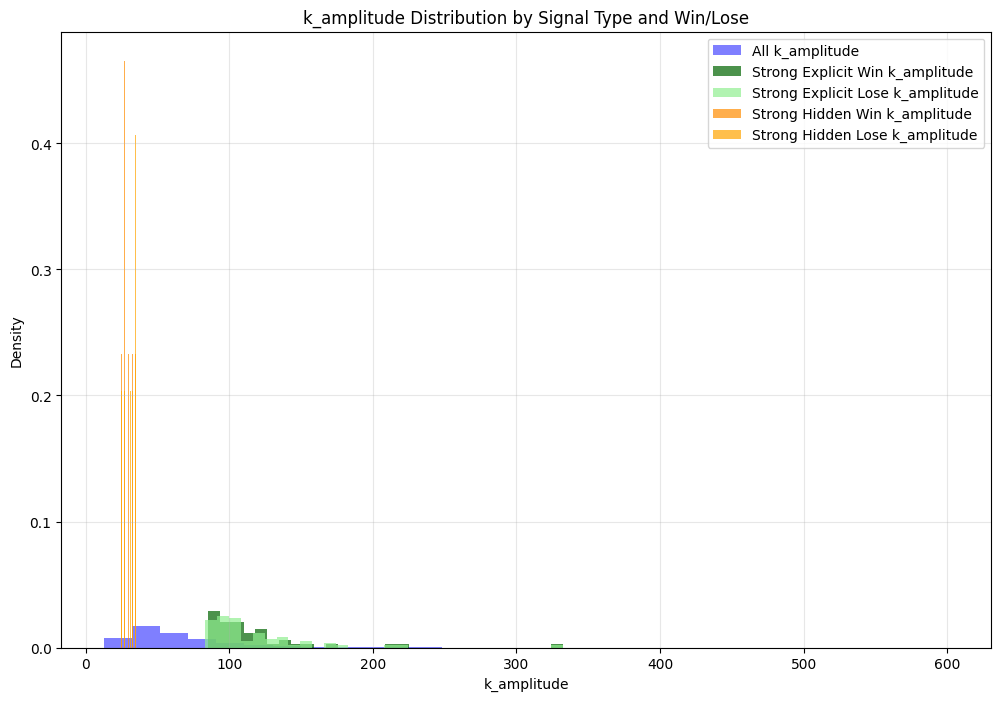

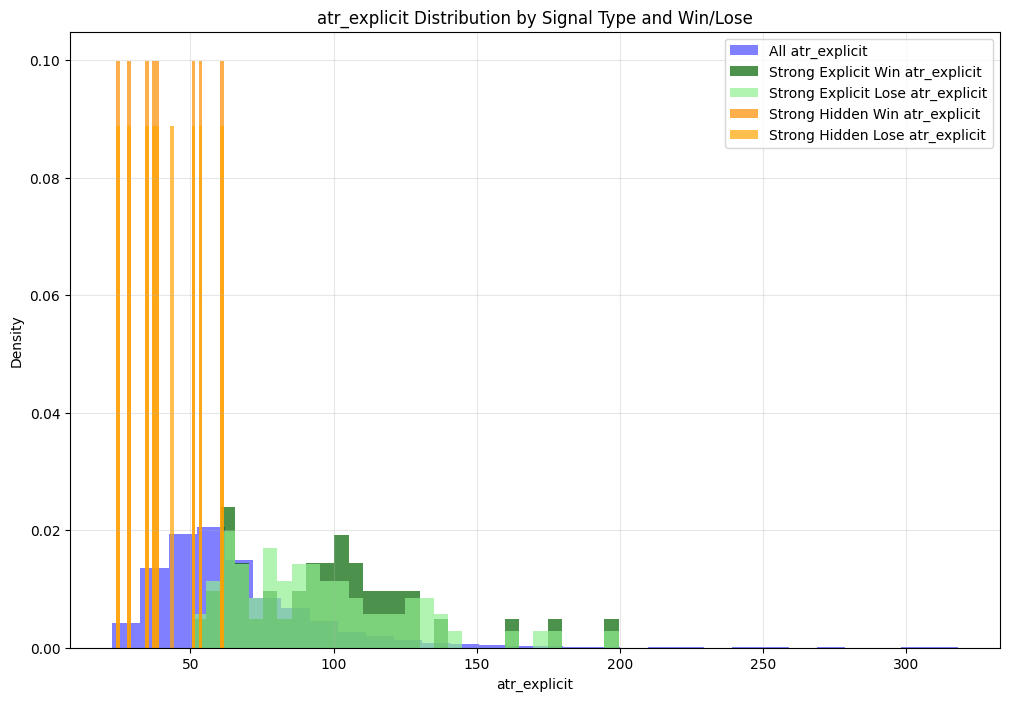

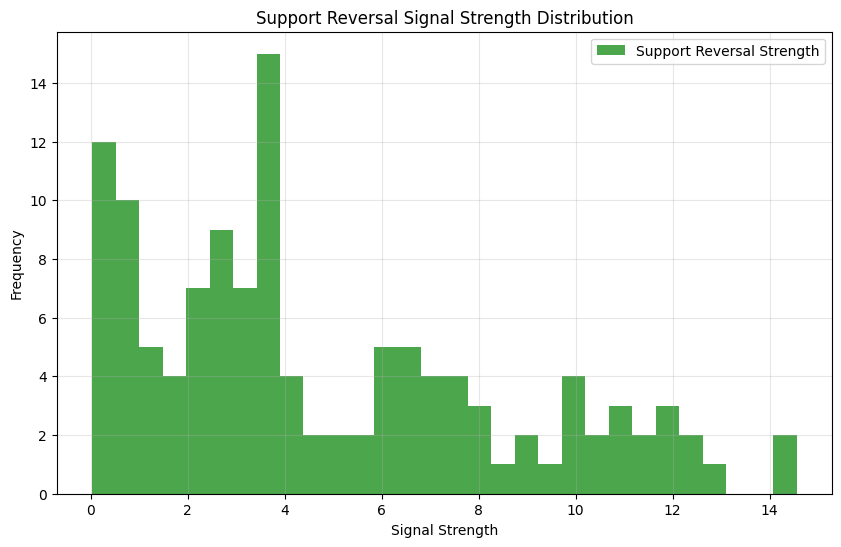

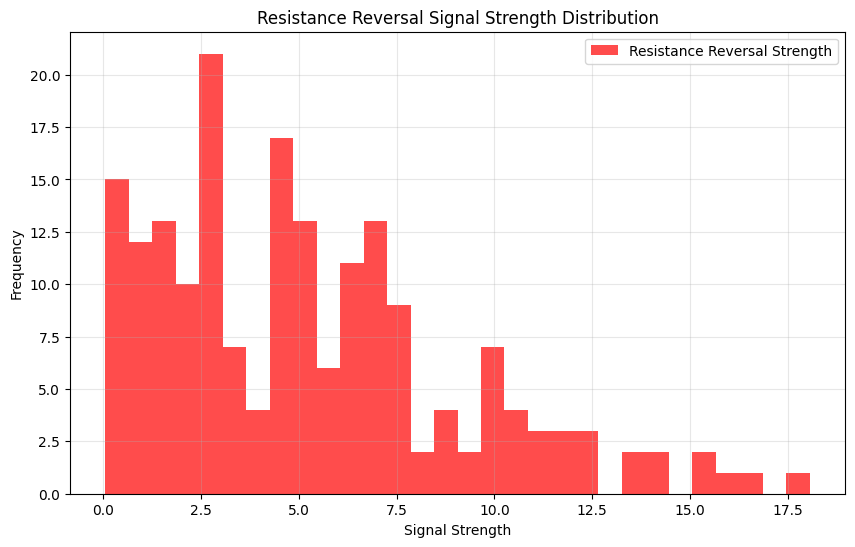

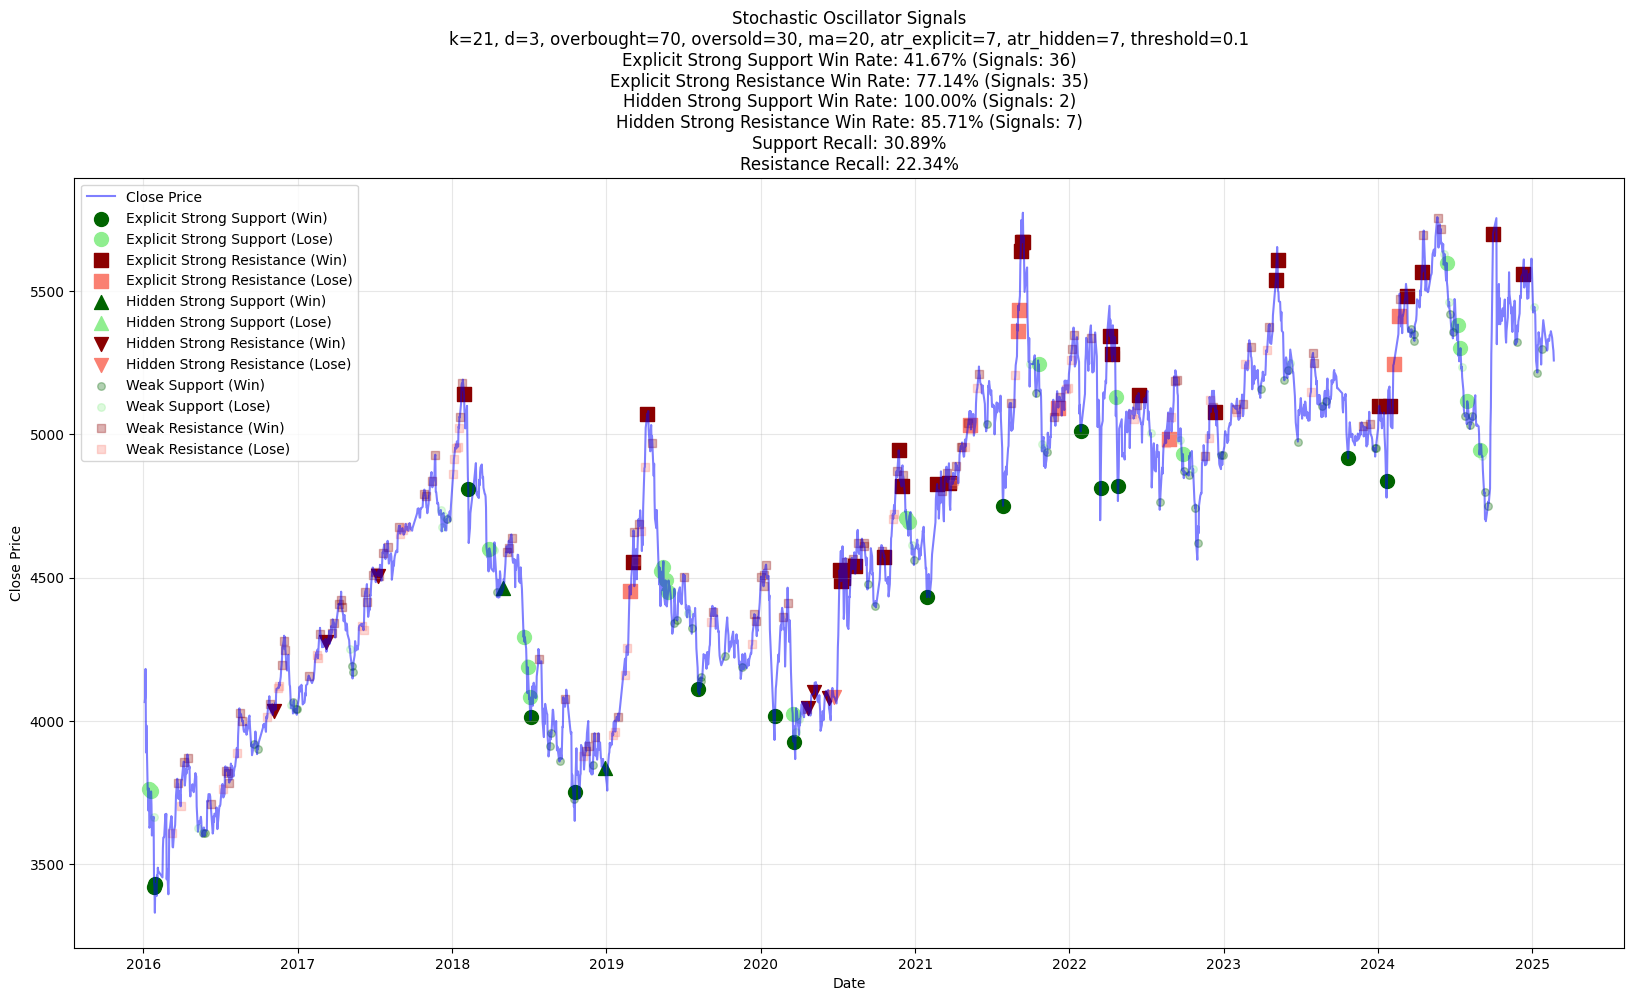

In [4]:
# 图表展示部分
# 输出结果
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result['support_win_rate']:.2%} (Signals: {result['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result['resistance_win_rate']:.2%} (Signals: {result['resistance_signals_count']})")
print(f"Strong Support Reversal Win Rate: {result['strong_support_win_rate']:.2%} (Signals: {result['strong_support_signals_count']})")
print(f"Strong Resistance Reversal Win Rate: {result['strong_resistance_win_rate']:.2%} (Signals: {result['strong_resistance_signals_count']})")
print(f"Explicit Strong Support Win Rate: {result['explicit_strong_support_win_rate']:.2%} (Signals: {result['explicit_strong_support_signals_count']})")
print(f"Explicit Strong Resistance Win Rate: {result['explicit_strong_resistance_win_rate']:.2%} (Signals: {result['explicit_strong_resistance_signals_count']})")
print(f"Hidden Strong Support Win Rate: {result['hidden_strong_support_win_rate']:.2%} (Signals: {result['hidden_strong_support_signals_count']})")
print(f"Hidden Strong Resistance Win Rate: {result['hidden_strong_resistance_win_rate']:.2%} (Signals: {result['hidden_strong_resistance_signals_count']})")
print(f"Support Recall: {result['support_recall']:.2%}")
print(f"Resistance Recall: {result['resistance_recall']:.2%}")

# 保存结果
csv_path = '../data/stochastic_signals_optimized.csv'
result['detailed_df'].to_csv(csv_path, index=True)
print(f"\nDetailed DataFrame saved to: {csv_path}")

# 显示尾部250行
print("\nDetailed DataFrame (Last 250 Rows):")
display(result['detailed_df'][['open', 'high', 'low', 'close', 'volume', 'reversal', 'signal_strength', 'is_strong', 'is_strong_explicit', 'is_strong_hidden', 'support_target', 'resistance_target', 'future_high', 'future_low', 'support_win', 'resistance_win']].tail(250))

# 绘制图表
df_visual = result['detailed_df']

# 图1：k_amplitude分布（按strong_explicit/strong_hidden分类，增加Win/Lose）
plt.figure(figsize=(12, 8))
plt.hist(df_visual['k_amplitude'].dropna(), bins=30, color='blue', alpha=0.5, label='All k_amplitude', density=True)
plt.hist(df_visual[(df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1) | (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)]['k_amplitude'].dropna(), bins=30, color='darkgreen', alpha=0.7, label='Strong Explicit Win k_amplitude', density=True)
plt.hist(df_visual[(df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0) | (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)]['k_amplitude'].dropna(), bins=30, color='lightgreen', alpha=0.7, label='Strong Explicit Lose k_amplitude', density=True)
plt.hist(df_visual[(df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1) | (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)]['k_amplitude'].dropna(), bins=30, color='darkorange', alpha=0.7, label='Strong Hidden Win k_amplitude', density=True)
plt.hist(df_visual[(df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0) | (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)]['k_amplitude'].dropna(), bins=30, color='orange', alpha=0.7, label='Strong Hidden Lose k_amplitude', density=True)
plt.title('k_amplitude Distribution by Signal Type and Win/Lose')
plt.xlabel('k_amplitude')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 图2：atr_explicit分布（按strong_explicit/strong_hidden分类，增加Win/Lose）
plt.figure(figsize=(12, 8))
atr_explicit = ATR(df_visual['high'], df_visual['low'], df_visual['close'], period=best_params['atr_period_explicit'])
plt.hist(atr_explicit.dropna(), bins=30, color='blue', alpha=0.5, label='All atr_explicit', density=True)
plt.hist(atr_explicit[(df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1) | (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)].dropna(), bins=30, color='darkgreen', alpha=0.7, label='Strong Explicit Win atr_explicit', density=True)
plt.hist(atr_explicit[(df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0) | (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)].dropna(), bins=30, color='lightgreen', alpha=0.7, label='Strong Explicit Lose atr_explicit', density=True)
plt.hist(atr_explicit[(df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1) | (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)].dropna(), bins=30, color='darkorange', alpha=0.7, label='Strong Hidden Win atr_explicit', density=True)
plt.hist(atr_explicit[(df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0) | (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)].dropna(), bins=30, color='orange', alpha=0.7, label='Strong Hidden Lose atr_explicit', density=True)
plt.title('atr_explicit Distribution by Signal Type and Win/Lose')
plt.xlabel('atr_explicit')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 图3：Support Reversal强度分布
plt.figure(figsize=(10, 6))
support_signals = df_visual[df_visual['reversal'] == 'support reversal']
plt.hist(support_signals['signal_strength'].dropna(), bins=30, color='green', alpha=0.7, label='Support Reversal Strength')
plt.title('Support Reversal Signal Strength Distribution')
plt.xlabel('Signal Strength')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 图4：Resistance Reversal强度分布
plt.figure(figsize=(10, 6))
resistance_signals = df_visual[df_visual['reversal'] == 'resistance reversal']
plt.hist(resistance_signals['signal_strength'].dropna(), bins=30, color='red', alpha=0.7, label='Resistance Reversal Strength')
plt.title('Resistance Reversal Signal Strength Distribution')
plt.xlabel('Signal Strength')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 图5：增强随机信号图
plt.figure(figsize=(20, 10))  # 放大图片大小
plt.plot(df_visual.index, df_visual['close'], label='Close Price', color='blue', alpha=0.5)

# 显性强信号
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 1)]['close'],
            color='darkgreen', marker='o', label='Explicit Strong Support (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['support_win'] == 0)]['close'],
            color='lightgreen', marker='o', label='Explicit Strong Support (Lose)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
            color='darkred', marker='s', label='Explicit Strong Resistance (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_explicit'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
            color='salmon', marker='s', label='Explicit Strong Resistance (Lose)', s=100)

# 隐秘强信号
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 1)]['close'],
            color='darkgreen', marker='^', label='Hidden Strong Support (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['support_win'] == 0)]['close'],
            color='lightgreen', marker='^', label='Hidden Strong Support (Lose)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 1)]['close'],
            color='darkred', marker='v', label='Hidden Strong Resistance (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong_hidden'] == 1) & (df_visual['resistance_win'] == 0)]['close'],
            color='salmon', marker='v', label='Hidden Strong Resistance (Lose)', s=100)

# 弱信号
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 1)]['close'],
            color='darkgreen', marker='o', label='Weak Support (Win)', s=30, alpha=0.3)
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['is_strong'] == 0) & (df_visual['support_win'] == 0)]['close'],
            color='lightgreen', marker='o', label='Weak Support (Lose)', s=30, alpha=0.3)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 1)]['close'],
            color='darkred', marker='s', label='Weak Resistance (Win)', s=30, alpha=0.3)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['is_strong'] == 0) & (df_visual['resistance_win'] == 0)]['close'],
            color='salmon', marker='s', label='Weak Resistance (Lose)', s=30, alpha=0.3)

# 增强标题信息
title = (
    f'Stochastic Oscillator Signals\n'
    f'k={best_params["k_period"]}, d={best_params["d_period"]}, overbought={best_params["overbought"]}, oversold={best_params["oversold"]}, ma={best_params["ma_period"]}, atr_explicit={best_params["atr_period_explicit"]}, atr_hidden={best_params["atr_period_hidden"]}, threshold={best_params["strength_threshold"]:.1f}\n'
    f'Explicit Strong Support Win Rate: {result["explicit_strong_support_win_rate"]:.2%} (Signals: {result["explicit_strong_support_signals_count"]})\n'
    f'Explicit Strong Resistance Win Rate: {result["explicit_strong_resistance_win_rate"]:.2%} (Signals: {result["explicit_strong_resistance_signals_count"]})\n'
    f'Hidden Strong Support Win Rate: {result["hidden_strong_support_win_rate"]:.2%} (Signals: {result["hidden_strong_support_signals_count"]})\n'
    f'Hidden Strong Resistance Win Rate: {result["hidden_strong_resistance_win_rate"]:.2%} (Signals: {result["hidden_strong_resistance_signals_count"]})\n'
    f'Support Recall: {result["support_recall"]:.2%}\n'
    f'Resistance Recall: {result["resistance_recall"]:.2%}'
)
plt.title(title, fontsize=12)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()